# Characteristics Exploration

## Prepare Data

### Installs

In [1]:
#!python -m pip install numpy pandas torch matplotlib sklearn torchvision tqdm opencv-python
#!python -m pip install albumentations --user

### Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import tqdm.auto as tqdm

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import torchvision.models as models

plt.style.use('seaborn')

import DiagnosisFunctions.tools as tools

import albumentations as A
import torchvision.transforms.functional as TF

### Get splits

In [3]:
(train_path, train_target), (val_path, val_target), (test_path, test_target), le = tools.get_splits_characteristics()

train_set    = tools.CharacteristicsDataset(path = train_path, target = train_target, size = [200, 200])
train_loader = DataLoader(train_set, batch_size=16)

val_set    = tools.CharacteristicsDataset(path = val_path, target = val_target, size = [200, 200])
val_loader = DataLoader(val_set, batch_size=16)

test_set    = tools.CharacteristicsDataset(path = test_path, target = test_target, size = [200, 200])
test_loader = DataLoader(test_set, batch_size=16)

## Create network

In [7]:
n_classes = 6 #8
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            #nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

### Train network

In [99]:
def predict(pred, threshold=0.5):
    return np.array(pred > threshold, dtype=float)

In [197]:
def calculate_metrics(pred, target):
    assert len(pred) == len(target)
    return {#'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            #'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            #'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            #'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            #'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            #'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples', zero_division=0),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples', zero_division=0),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples', zero_division=0)}


In [198]:
cnn = CNN()

criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters())

num_epochs = 15

threshold = 0.5

train_losses     = []
train_accuracies = []

val_losses       = []
val_accuracies   = []


for epoch in tqdm.tqdm(range(num_epochs), unit='epoch', desc="Epoch"):

    #Epochs start @ 1 now.
    epoch += 1

    ## -- Training -- ##
    cnn.train()
    train_loss = 0
    predictions  = []
    ground_truth = []
    
    for data in train_loader:

        # Fetch images and targets from train loader.
        images, targets = data
        
        # Get that stuff on the GPU
        #images  = images.to(device)
        #targets = targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(images)
        
        loss = criterion(outputs, targets.type(torch.float))
        loss.backward()
        optimizer.step()

        # Add the batch loss
        train_loss += loss.item()
        
        # Determine predictions and cast to numpy
        predidctions_numpy = predict(outputs.detach().numpy())
        targets_numpy = targets.detach().numpy()

        # Save predictions and targets
        predictions.append(predidctions_numpy)
        ground_truth.append(targets_numpy)

    # Append this epoch's statistics. Make sure to call vstack on lists
    train_losses.append(train_loss)
    train_accuracies.append(calculate_metrics(np.vstack(ground_truth), np.vstack(predictions)))
    
    ## -- End of Training -- ##
    
    ## -- Validation -- ##
    cnn.eval()
    val_loss = 0
    predictions  = []
    ground_truth = []
    
    for data in val_loader:
    
        # Fetch images and targets from val loader.
        images, targets = data
        
        # Get that stuff on the GPU
        #images  = images.to(device)
        #targets = targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(images)
        
        loss = criterion(outputs, targets.type(torch.float))
        loss.backward()
        optimizer.step()

        # Add the batch loss
        val_loss += loss.item()

        # Determine predictions and cast to numpy
        predidctions_numpy = predict(outputs.detach().numpy())
        targets_numpy = targets.detach().numpy()

        # Save predictions and targets
        predictions.append(predidctions_numpy)
        ground_truth.append(targets_numpy)

    # Append this epoch's statistics. Make sure to call vstack on lists
    val_losses.append(val_loss)
    val_accuracies.append(calculate_metrics(np.vstack(ground_truth), np.vstack(predictions)))
    ## -- End of Validation -- ##

Epoch:   0%|          | 0/15 [00:00<?, ?epoch/s]

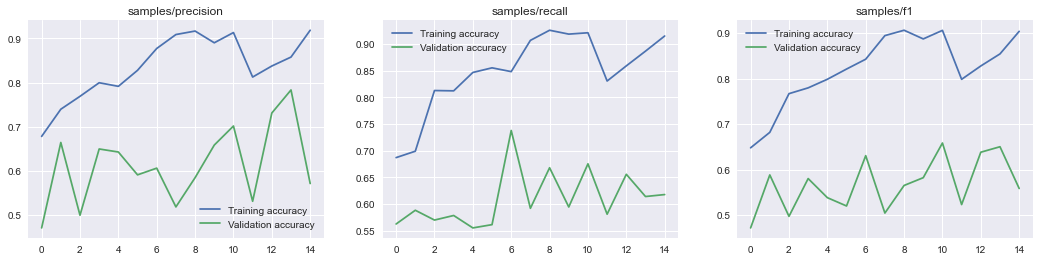

In [199]:
titles = ['samples/precision', 'samples/recall', 'samples/f1']

figWidth = 18
figHeight = 4
nRow = 1
nCol = len(titles)

fig, axes = plt.subplots(nRow, nCol, figsize = (figWidth, figHeight))
acc_idx = -1
for i in range(0,nRow*nCol):
    r = i//nCol
    c = i%nCol
    axes[c].plot(np.arange(0, num_epochs), [train_accuracies[i][titles[c]] for i in range(0,num_epochs)], label='Training accuracy')
    axes[c].plot(np.arange(0, num_epochs), [val_accuracies[i][titles[c]] for i in range(0,num_epochs)], label='Validation accuracy')
    axes[c].set_title(titles[i])
    axes[c].legend()
plt.show()